In [1]:
from datetime import datetime, timedelta
from os import listdir

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import numpy as np
from netCDF4 import Dataset
from scipy import interpolate
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

mpl.rcParams.update(mpl.rcParamsDefault)
import math
import pickle
from datetime import datetime, timedelta, timezone

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.cm as cm
import metpy.calc as mpcalc
import pandas as pd
import xarray
from cartopy.util import add_cyclic_point

In [2]:
output_directory = "/home/owpo6214/Desktop/DynamicVis/2dplots/"

new_ncfile1 = Dataset(output_directory + "1min/08-24_UT_sampledTracks_1min_zonal_midpoints.nc")
new_ncfile2 = Dataset(output_directory + "1min/08-24_UT_sampledTracks_1min_meridional_midpoints.nc")
new_ncfile3 = Dataset(output_directory + "1min/08-24_UT_sampledTracks_1min_temp.nc")
new_ncfile4 = Dataset(output_directory + "1min/08-24_UT_sampledTracks_1min_oxygen.nc")
new_ncfile5 = Dataset(output_directory + "1min/08-24_UT_sampledTracks_1min_pres.nc")

In [3]:
time = np.array(new_ncfile1.variables["time"][:])
altitudes = np.array(new_ncfile1.variables["altitudes"][:])
zonal_wind = np.array(new_ncfile1.variables["sampled_zonal"][:, :, :])
sat_position = np.array(new_ncfile1.variables["sat_position"][:, :, :])

meridional_wind = np.array(new_ncfile2.variables["sampled_meridional"][:, :, :])

temperature = np.array(new_ncfile3.variables["sampled_temp"][:, :, :])
altitudes2 = np.array(new_ncfile3.variables["altitudes"][:])

oxygen_concentration = np.array(new_ncfile4.variables["sampled_o"][:, :, :])

pressure = np.array(new_ncfile5.variables["sampled_temp"][:, :, :])

# nc_var3 = new_ncfile2.createVariable("sampled_zonal", "f8", ("Time", "Sats","Altitudes"))
# nc_var4 = new_ncfile2.createVariable("sat_position", "f8", ("Time", "Sats","LatLon"))

In [4]:
k_b = 1.380649e-23 # J/K
n = pressure / (k_b * temperature)

oxygen_density = oxygen_concentration * n

In [12]:
print(zonal_wind.shape)

(180, 2, 72)


In [16]:
print(altitudes)

[110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123.
 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137.
 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151.
 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165.
 166. 167. 168. 169. 170. 175. 180. 185. 190. 195. 200. 210. 220. 230.
 240. 250.]


In [5]:
start_time = datetime(2024,8,24,3,0)
time_interval = timedelta(minutes=1)

In [6]:
def create_gif_for_satellite(sat_idx, filename):
    fig, axes = plt.subplots(1, 2, figsize=(6,4))
    fig.patch.set_facecolor("#0D131F")
    
    for ax in axes:
        ax.set_ylim(altitudes[0], altitudes[-1])
        ax.set_xlim(-400, 400)
        ax.axvline(0, color='white', linewidth = 0.8, linestyle = '--')
        ax.set_ylabel('Altitude [km]', color='white')
        ax.set_xlabel('Wind Speed [m/s]', color='white')

        ax.set_facecolor("#0D131F")
        ax.tick_params(axis="both", colors="white")
        ax.spines["top"].set_color("white")
        ax.spines["bottom"].set_color("white")
        ax.spines["left"].set_color("white")
        ax.spines["right"].set_color("white")

    # timestamp_txt = fig.suptitle("", fontsize=14, color='white')
    
    def update(t):
        for ax in axes:
            ax.clear()
            ax.set_ylim(altitudes[0], altitudes[-1])
            ax.set_xlim(-400, 400)
            ax.axvline(0, color='white', linewidth = 0.8, linestyle = '--')
            ax.set_ylabel('Altitude [km]', color='white')
            ax.set_xlabel('Wind Speed [m/s]', color='white')
        axes[0].set_title(f'Zonal Wind', color='white')
        axes[1].set_title(f"Meridional Wind", color='white')

        ax.set_facecolor("#0D131F")
        ax.tick_params(axis="both", colors="white")
        ax.spines["top"].set_color("white")
        ax.spines["bottom"].set_color("white")
        ax.spines["left"].set_color("white")
        ax.spines["right"].set_color("white")
    
        for prev_t in range(t):
            # axes[0].plot(zonal_wind[prev_t, sat_idx, :], altitudes, color='gray', lw=1, alpha=0.5)
            axes[0].plot(zonal_wind[t, sat_idx, :], altitudes, color='#6cce24', lw=2)
            
        for prev_t in range(t):
            # axes[1].plot(meridional_wind[prev_t, sat_idx, :], altitudes, color='gray', lw=1, alpha=0.5)
            axes[1].plot(meridional_wind[t, sat_idx, :], altitudes, color='#6cce24', lw=2)

        # current_time = start_time + t * time_interval
        # timestamp_txt.set_text(f"Time: {current_time.strftime('%H:%M UT')}")
    
    gif_writer = PillowWriter(fps=20)
    with gif_writer.saving(fig, filename, dpi=150):
        for t in range(zonal_wind.shape[0]):
            update(t)
            gif_writer.grab_frame()
    
    plt.close(fig)        

In [7]:
create_gif_for_satellite(1, "left_side_winds20.gif")
create_gif_for_satellite(0, "right_side_winds20.gif")

In [8]:

satellite_labels = [f"L{i + 1}" for i in range(4)]
time_steps = temperature.shape[0]

In [9]:
def create_bar_chart_gif(filename):
    # Create a figure
    fig, axes = plt.subplots(1, 2, figsize=(4,3))
    plt.tight_layout(pad=3)
    fig.patch.set_facecolor("#0D131F")
    
    # Titles and axis labels
    axes[0].set_title("Temperature (K)", color="white")
    axes[1].set_title("Oxygen Density (#/m3)", color="white")
    
    axes[0].set_ylim(0, np.nanmax(temperature) + 50)  # Set y-limit for temperature
    axes[1].set_ylim(0, 6e16)  # Set y-limit for oxygen concentration

    # X-axis setup
    x = np.arange(len(satellite_labels))  # Satellite indices
    for ax in axes:
        ax.set_xticks(x)
        ax.set_xticklabels(satellite_labels, color="white")
        ax.set_xlabel("Satellites", color="white")
        # ax.set_ylabel("Value")

        ax.set_facecolor("#0D131F")
        ax.tick_params(axis="both", colors="white")
        ax.spines["top"].set_color("white")
        ax.spines["bottom"].set_color("white")
        ax.spines["left"].set_color("white")
        ax.spines["right"].set_color("white")

    # Generate color gradients
    temp_colors = cm.Blues(np.linspace(0.4, 0.9, 4))  # Shades of blue for temperature
    oxy_colors = cm.Greens(np.linspace(0.4, 0.9, 4))  # Shades of green for oxygen

    # Initialize bar containers
    bars_temp = axes[0].bar(x, temperature[0, :, 6], color=temp_colors, alpha=0.8)
    bars_oxy = axes[1].bar(x, oxygen_density[0, :, 6], color=oxy_colors, alpha=0.8)

    # Add a placeholder for the timestamp
    # timestamp_text = fig.suptitle("", fontsize=14, color="white")

    def update(t):
        # Update bar heights
        for bar, new_height in zip(bars_temp, temperature[t, :, 6]):
            bar.set_height(new_height)
        for bar, new_height in zip(bars_oxy, oxygen_density[t, :, 6]):
            bar.set_height(new_height)
        
        # Update timestamp
        # current_time = start_time + t * time_interval
        # timestamp_text.set_text(f"Time: {current_time.strftime('%H:%M UT')}")

    # Create GIF writer
    gif_writer = PillowWriter(fps=20)
    with gif_writer.saving(fig, filename, dpi=150):
        for t in range(time_steps):
            update(t)
            gif_writer.grab_frame()

    plt.close(fig)

# Generate the GIF
create_bar_chart_gif("temperature_oxygen_barchart20.gif")

In [25]:
# def create_wind_vector_gif(filename):
#     # Create a figure with one subplot per satellite
#     fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#     # Set up the plot limits for each subplot
#     max_wind = 2*max(np.nanmax(np.abs(zonal_wind[:, [0,1], 30])),
#                    np.nanmax(np.abs(meridional_wind[:, [0,1], 30])))
#     for ax in axes:
#         ax.set_xlim(-max_wind, max_wind)
#         ax.set_ylim(-max_wind, max_wind)
#         ax.set_xlabel("Zonal Wind (m/s)")
#         ax.set_ylabel("Meridional Wind (m/s)")
#         ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
#         ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
#         ax.grid(True)

#     # Set titles for each subplot
#     axes[1].set_title("Right Side")
#     axes[0].set_title("Left Side")

#     # Initialize quiver objects for each subplot
#     quivers = []
#     for ax in axes:
#         quiver = ax.quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=0.25, width=0.03, color='orange', alpha=0.8)
#         quivers.append(quiver)

#     # Add a placeholder for the timestamp
#     timestamp_text = fig.suptitle("", fontsize=14)

#     def update(t):
#         for quiver, sat, ax in zip(quivers, [1,0], axes):
#             # Update quiver for the current satellite at the selected altitude
#             quiver.set_UVC(zonal_wind[t, sat, 30], meridional_wind[t, sat, 30])
        
#         # Update timestamp
#         current_time = start_time + t * time_interval
#         timestamp_text.set_text(f"Winds at 140km: {current_time.strftime('%H:%M UT')}")

#     # Create GIF writer
#     gif_writer = PillowWriter(fps=6)
#     with gif_writer.saving(fig, filename, dpi=150):
#         for t in range(time_steps):
#             update(t)
#             gif_writer.grab_frame()

#     plt.close(fig)

# # Generate the GIF
# create_wind_vector_gif("wind_vector_satellites.gif")

In [23]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import PillowWriter
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors

# # Sample data: Replace these with your actual data
# time_steps = 252
# satellites = 4


# # Select the first 2 satellites and altitude index 6
# selected_satellites = [1,0]  # Indices for first 2 satellites
# altitude_idx = 30  # Altitude index

# def create_wind_vector_gif(filename):
#     # Create a figure with one subplot per satellite
#     fig, axes = plt.subplots(1, 2, figsize=(14, 7))

#     # Set up the plot limits for each subplot
#     max_wind = 2*max(np.nanmax(np.abs(zonal_wind[:, selected_satellites, altitude_idx])),
#                    np.nanmax(np.abs(meridional_wind[:, selected_satellites, altitude_idx])))
#     for ax in axes:
#         ax.set_xlim(-max_wind, max_wind)
#         ax.set_ylim(-max_wind, max_wind)
#         ax.set_xlabel("Zonal Wind (m/s)", fontsize=12)
#         ax.set_ylabel("Meridional Wind (m/s)", fontsize=12)
#         ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
#         ax.axvline(0, color='gray', linewidth=0.8, linestyle='--')
#         ax.grid(color='lightgray', linestyle='--', linewidth=0.5)
#         ax.set_aspect('equal')

#     # Set titles for each subplot
#     axes[0].set_title("Left Side", fontsize=14)
#     axes[1].set_title("Right Side", fontsize=14)

#     # Add a colormap and normalize
#     cmap = cm.Oranges  # Choose a colormap
#     norm = mcolors.Normalize(vmin=0, vmax=max_wind)  # Normalize magnitude values

#     # Add a placeholder for the timestamp
#     timestamp_text = fig.suptitle("", fontsize=16)

#     # Track the current quivers
#     current_quivers = [None] * len(axes)

#     def update(t):
#         for i, (ax, sat) in enumerate(zip(axes, selected_satellites)):
#             # Remove the previous quiver
#             if current_quivers[i] is not None:
#                 current_quivers[i].remove()

#             # Calculate wind components
#             u = zonal_wind[t, sat, altitude_idx]
#             v = meridional_wind[t, sat, altitude_idx]
#             magnitude = np.sqrt(u**2 + v**2)

#             # Map magnitude to color
#             color = cmap(norm(magnitude))

#             # Draw the new quiver
#             current_quivers[i] = ax.quiver(
#                 0, 0, u, v,
#                 angles='xy',
#                 scale_units='xy',
#                 scale=0.25,
#                 color=color,
#                 width=0.03
#             )

#             # Add vector magnitude annotation
#             # ax.text(0.05, 0.9, f"Magnitude: {magnitude:.1f} m/s",
#                     # transform=ax.transAxes, fontsize=10, color='darkred')

#         # Update timestamp
#         current_time = start_time + t * time_interval
#         timestamp_text.set_text(f"Winds at 140km: {current_time.strftime('%H:%M UT')}")

#     # Create GIF writer
#     gif_writer = PillowWriter(fps=6)
#     with gif_writer.saving(fig, filename, dpi=150):
#         for t in range(time_steps):
#             update(t)
#             gif_writer.grab_frame()

#     plt.close(fig)

# # Generate the GIF
# create_wind_vector_gif("wind_vector_satellites_altitude6_colored_fixed.gif")


IndexError: index 180 is out of bounds for axis 0 with size 180

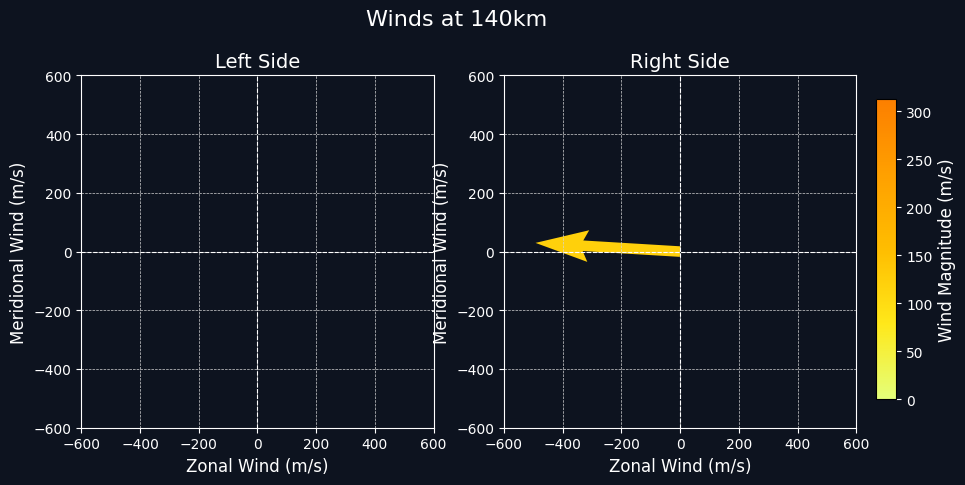

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Sample data: Replace these with your actual data
time_steps = 252
satellites = 4

# Select the first 2 satellites and altitude index 6
selected_satellites = [1, 0]  # Indices for first 2 satellites
altitude_idx = 30  # Altitude index

def create_wind_vector_gif(filename):
    # Create a figure with one subplot per satellite
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    fig.patch.set_facecolor("#0D131F")

    # Set up the plot limits for each subplot
    max_wind = 2*max(np.nanmax(np.abs(zonal_wind[:, selected_satellites, altitude_idx])),
                   np.nanmax(np.abs(meridional_wind[:, selected_satellites, altitude_idx])))
    for ax in axes:
        ax.set_xlim(-600, 600)
        ax.set_ylim(-600, 600)
        ax.set_xlabel("Zonal Wind (m/s)", fontsize=12, color='white')
        ax.set_ylabel("Meridional Wind (m/s)", fontsize=12, color='white')
        ax.axhline(0, color='white', linewidth=0.8, linestyle='--')
        ax.axvline(0, color='white', linewidth=0.8, linestyle='--')
        ax.grid(color='lightgray', linestyle='--', linewidth=0.5)
        ax.set_aspect('equal')

        ax.set_facecolor("#0D131F")
        ax.tick_params(axis="both", colors="white")
        ax.spines["top"].set_color("white")
        ax.spines["bottom"].set_color("white")
        ax.spines["left"].set_color("white")
        ax.spines["right"].set_color("white")

    # Set titles for each subplot
    axes[0].set_title("Left Side", fontsize=14, color='white')
    axes[1].set_title("Right Side", fontsize=14, color='white')

    # Global Title
    fig.suptitle("Winds at 140km", fontsize=16, color='white')

    # Add a colormap and normalize
    cmap = cm.Wistia  # Choose a colormap
    norm = mcolors.Normalize(vmin=0, vmax=max_wind)  # Normalize magnitude values

    # Add a single shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Colorbar position
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)

    # Set colorbar label color
    cbar.set_label("Wind Magnitude (m/s)", fontsize=12, color='white')

    # Set colorbar tick labels color
    cbar.ax.yaxis.set_tick_params(color='white')  # Change tick color
    plt.setp(cbar.ax.get_yticklabels(), color='white')  # Change tick label color


    # Track the current quivers
    current_quivers = [None] * len(axes)

    # Add a placeholder for the timestamp
    # timestamp_text = fig.suptitle("", fontsize=16, color='white')

    def update(t):
        for i, (ax, sat) in enumerate(zip(axes, selected_satellites)):
            # Remove the previous quiver
            if current_quivers[i] is not None:
                current_quivers[i].remove()

            # Calculate wind components
            u = zonal_wind[t, sat, altitude_idx]
            v = meridional_wind[t, sat, altitude_idx]
            magnitude = np.sqrt(u**2 + v**2)

            # Map magnitude to color
            color = cmap(norm(magnitude))

            # Draw the new quiver
            current_quivers[i] = ax.quiver(
                0, 0, u, v,
                angles='xy',
                scale_units='xy',
                scale=0.25,
                color=color,
                width=0.03
            )

            # Add vector magnitude annotation
            # ax.text(0.05, 0.9, f"Magnitude: {magnitude:.1f} m/s",
            #         transform=ax.transAxes, fontsize=10, color='darkred')

        # Update timestamp
        # current_time = start_time + t * time_interval
        # timestamp_text.set_text(f"Winds at 140km: {current_time.strftime('%H:%M UT')}")

    # Create GIF writer
    gif_writer = PillowWriter(fps=20)
    with gif_writer.saving(fig, filename, dpi=150):
        for t in range(time_steps):
            update(t)
            gif_writer.grab_frame()

    plt.close(fig)

# Generate the GIF
create_wind_vector_gif("wind_vector_satellites_altitude6_shared_colorbar20.gif")


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import datetime

# Define time parameters
start_time = datetime.datetime(2024,8,24,3,0)  # Example start time
time_steps = 1000  # Number of frames
time_interval = datetime.timedelta(minutes=1)  # Time step interval

# Create figure
fig, ax = plt.subplots(figsize=(6, 3))
fig.patch.set_facecolor("#0D131F")  # Set dark background
ax.axis("off")  # Hide axes

# Add a timestamp placeholder
timestamp_text = fig.suptitle("", fontsize=24, color='white', fontweight="bold")

def update(t):
    """Update function to change timestamp in each frame."""
    current_time = start_time + t * time_interval
    timestamp_text.set_text(f"Time: {current_time.strftime('%H:%M UT')}")

# Create GIF writer
gif_writer = PillowWriter(fps=20)
with gif_writer.saving(fig, "timestamp_animation.gif", dpi=150):
    for t in range(time_steps):
        update(t)
        gif_writer.grab_frame()

plt.close(fig)
